# Convolutional Neural Network

In [1]:
import numpy as np

from tensorflow.keras import layers, models, optimizers, utils, datasets, callbacks
from notebooks.utils import display

2023-06-07 11:28:24.989994: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-07 11:28:25.111159: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Customize Setup

In [2]:
! pip install --no-index -f https://github.com/dreoporto/ptmlib/releases ptmlib

from ptmlib.time import Stopwatch, AlertSounds
import ptmlib.model_tools as modt
import ptmlib.charts as pch

Looking in links: https://github.com/dreoporto/ptmlib/releases


In [3]:
main_stopwatch = Stopwatch()
main_stopwatch.start()

Start Time: Wed Jun  7 11:28:27 2023


## 0. Parameters

In [4]:
NUM_CLASSES = 10
BATCH_SIZE = 32
EPOCHS = 50
EARLY_STOP_TARGET = 0.85

## 1. Prepare the Data

In [5]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

In [6]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [7]:
y_train = utils.to_categorical(y_train, NUM_CLASSES)
y_test = utils.to_categorical(y_test, NUM_CLASSES)

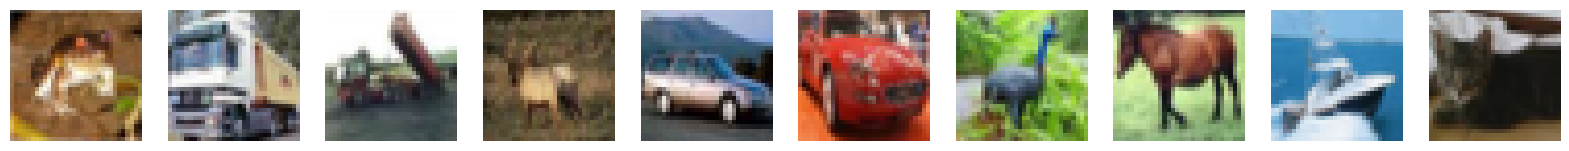

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


In [8]:
display(x_train[:10])
print(y_train[:10])

## 2. Build the model

In [9]:
input_layer = layers.Input((32, 32, 3))

x = layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same')(input_layer)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Flatten()(x)

x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(rate=0.5)(x)

x = layers.Dense(NUM_CLASSES)(x)
output_layer = layers.Activation('softmax')(x)

model = models.Model(input_layer, output_layer)

2023-06-07 11:28:28.931474: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-07 11:28:28.934026: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-07 11:28:28.934335: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-07 11:28:28.935039: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                             

### Early Stopping

In [11]:
class EarlyStoppingCallback(callbacks.Callback):

    def __init__(self, target_name, target_value):
        super().__init__()
        self.target_name = target_name
        self.target_value = target_value        

    def on_epoch_end(self, _, logs=None):

        if logs is None:
            logs = {}
        if logs.get(self.target_name) > self.target_value:
            print(f"\nReached {self.target_value * 100}% {self.target_name}; will stop training.")
            self.model.stop_training = True

In [12]:
early_callback = EarlyStoppingCallback(target_name = 'accuracy', target_value=EARLY_STOP_TARGET)

## 3. Train the model

In [13]:
opt = optimizers.Adam(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [14]:
stopwatch = Stopwatch()
stopwatch.start()

history = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle=True,
    validation_data=(x_test, y_test),
    callbacks=[early_callback]
)

stopwatch.stop()

Start Time: Wed Jun  7 11:28:30 2023
Epoch 1/50


2023-06-07 11:28:30.679779: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614400000 exceeds 10% of free system memory.
2023-06-07 11:28:30.978658: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614400000 exceeds 10% of free system memory.
2023-06-07 11:28:32.121923: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1563/1563 [==============================] - 25s 15ms/step - loss: 1.5574 - accuracy: 0.4576 - val_loss: 1.2542 - val_accuracy: 0.5544
Epoch 2/50
1563/1563 [==============================] - 23s 15ms/step - loss: 1.1382 - accuracy: 0.6001 - val_loss: 1.0814 - val_accuracy: 0.6113
Epoch 3/50
1563/1563 [==============================] - 23s 15ms/step - loss: 0.9941 - accuracy: 0.6536 - val_loss: 1.0366 - val_accuracy: 0.6325
Epoch 4/50
1563/1563 [==============================] - 23s 14ms/step - loss: 0.9167 - accuracy: 0.6813 - val_loss: 0.9911 - val_accuracy: 0.6530
Epoch 5/50
1563/1563 [==============================] - 23s 15ms/step - loss: 0.8510 - accuracy: 0.7024 - val_loss: 0.8624 - val_accuracy: 0.6983
Epoch 6/50
1563/1563 [==============================] - 23s 15ms/step - loss: 0.7992 - accuracy: 0.7230 - val_loss: 0.8421 - val_accuracy: 0.7092
Epoch 7/50
1563/1563 [==============================] - 23s 15ms/step - loss: 0.7551 - accuracy: 0.7385 - val_loss: 0.8158 - val_accura

Saved image: accuracy-20230607-113653.png


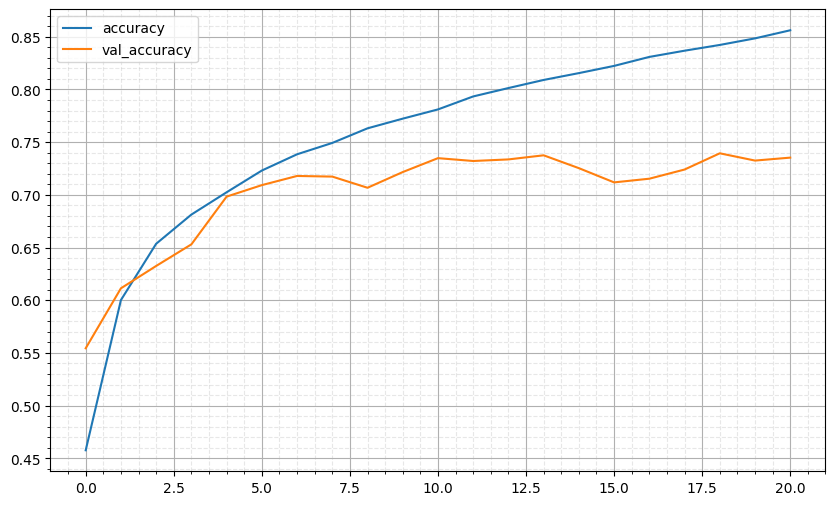

Saved image: loss-20230607-113654.png


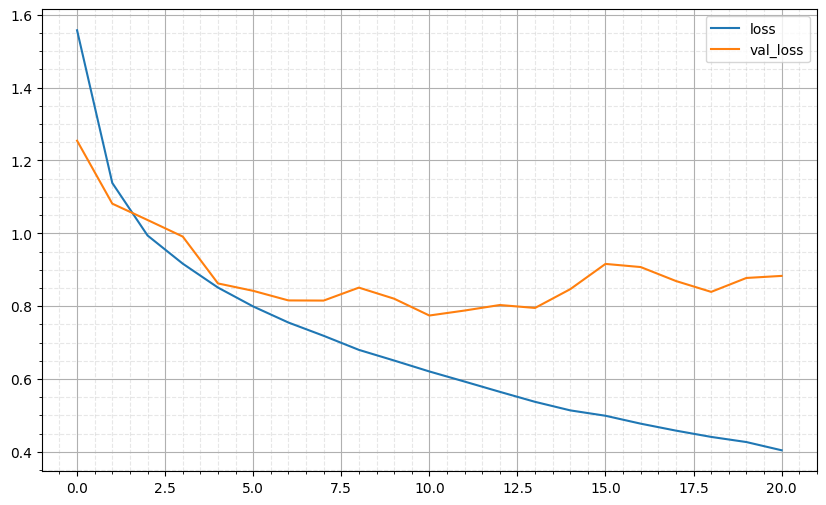

In [15]:
pch.show_history_chart(history, "accuracy", save_fig_enabled=True)
pch.show_history_chart(history, "loss", save_fig_enabled=True)

## 4. Evaluation

In [16]:
model.evaluate(x_test, y_test, batch_size=1000)

10/10 [==============================] - 1s 19ms/step - loss: 0.8831 - accuracy: 0.7353


[0.8831034898757935, 0.7353000044822693]

In [17]:
CLASSES = np.array(
    [
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ]
)

In [18]:
preds = model.predict(x_test)
preds_single = CLASSES[np.argmax(preds, axis=-1)]
actual_single = CLASSES[np.argmax(y_test, axis=-1)]

313/313 [==============================] - 1s 3ms/step


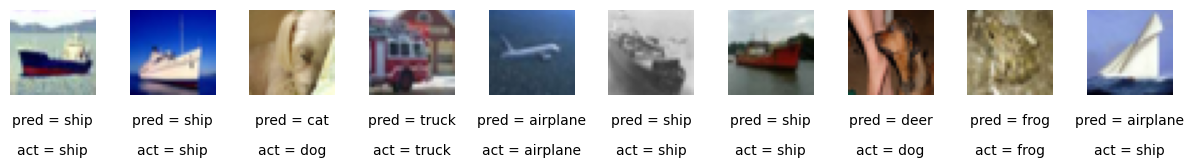

In [19]:
import matplotlib.pyplot as plt

n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        "pred = " + str(preds_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.7,
        "act = " + str(actual_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(img)

In [20]:
# ALL DONE!

main_stopwatch.stop(sound_path=AlertSounds.DORE)

End Time:   Wed Jun  7 11:36:57 2023
Elapsed seconds: 509.2635 (8.49 minutes)
